In [2]:
import nibabel as nib
import nibabel.nicom.dicomwrappers
import os
import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

/tmp/ipykernel_8331/981472426.py:2: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.dicomwrappers


Sul funzionamento del sistema di coordinate e matrice affine
https://nipy.org/nibabel/coordinate_systems.html

# Utility function

## Open dicom folder

In [3]:
def read_dicomdir(dir_path: str) -> list:
    # opening the dicom files in the dir
    dicom_files = [
        os.path.join(dir_path, f) 
        for f in os.listdir(dir_path)
    ]
    
    # Sort the files based on slice location (for this patient is already done)
    dicom_files.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)
    
    # read the actual dicom files
    slices = [pydicom.dcmread(f) for f in dicom_files]
    
    return slices

## Reconstruct 3d shape

In [4]:
def get_3d_shape(dicom_slices: list) -> np.ndarray:
    pixel_arrays = [s.pixel_array for s in dicom_slices]

    # stack the slices to create a 3d array
    volume_3d = np.stack(pixel_arrays, axis=0)
    
    # flip the dicom on the vertical axis
    return volume_3d[:, ::-1, :]

## Read the Multiphase MRI

In [30]:
def get_multiphase_mri(dir_path: str) -> list:
    volume = get_3d_shape(read_dicomdir(dir_path))
    l = np.array_split(volume, 5, axis=0)
    return (*l,)

# Patient 1

In [4]:
lesions_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
lesions_df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...


In [6]:
output_dir = "/media/bendico765/Crucial X9/MRI Lesions/NiftiFiles"
volume_3d = get_3d_shape(read_dicomdir(lesions_df.at[0, "Registered Ax T2 FSE path"]))
roi = np.load(lesions_df.at[0, "Cleaned Roi mask Filepath"]).astype("int8")
img = nibabel.nicom.dicomwrappers.wrapper_from_file("/media/bendico765/Crucial X9/MRI Lesions/manifest-1728494830954/Advanced-MRI-Breast-Lesions/AMBL-001/03-05-2004-NA-MRI BREASTS - Delayed contrast-93547/600.000000-Registered Ax T2 FSE-08519/1-083.dcm")
affine_matrix = img.affine

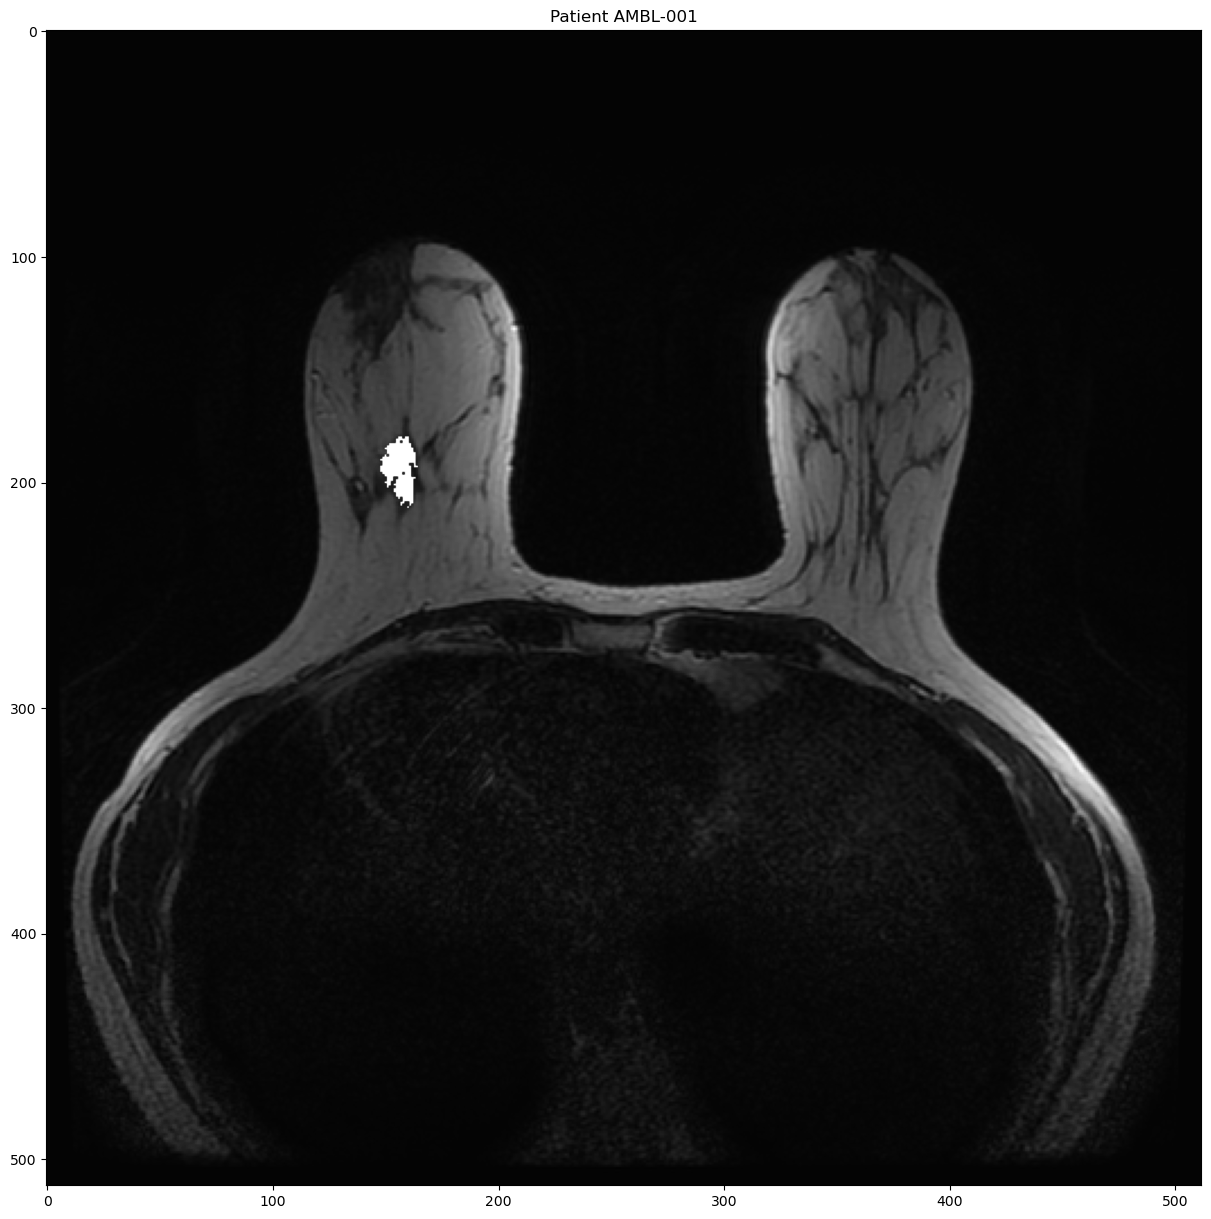

In [7]:
plt.figure(figsize=(15,15))
plt.title("Patient AMBL-001")
plt.imshow(volume_3d[83, :, :], cmap=plt.cm.gray)
plt.imshow(roi[83, :, :], cmap=plt.cm.gray, alpha = (roi[83, :, :] > 0 ).astype(float))

## 3D volume

Note how to cast from dicom to nifti we have to transpose the three dimensions: this is due to the fact that dicom has (z,y,x) while nifti has (x,y,z)

#### From DICOM to NIFTI

In [8]:
# get the affine matrix from a dicom slice
affine_matrix = nibabel.nicom.dicomwrappers.wrapper_from_file("/media/bendico765/Crucial X9/MRI Lesions/manifest-1728494830954/Advanced-MRI-Breast-Lesions/AMBL-001/03-05-2004-NA-MRI BREASTS - Delayed contrast-93547/600.000000-Registered Ax T2 FSE-08519/1-083.dcm").affine

# convert from dicom to nifti
nifti_image = nib.Nifti1Image(np.transpose(volume_3d, (2,1,0))[:,:,:], affine_matrix)
nib.save(nifti_image, f"{output_dir}/[Volume] AMBL-001")

# create the roi mask in nifti format
nifti_roi = nib.Nifti1Image(np.transpose(roi, (2,1,0))[:,:,:], affine_matrix)
nib.save(nifti_roi, f"{output_dir}/[Volume] AMBL-001 ROI")

#### Read the NIFTI file back

In [9]:
img = nib.load(f"{output_dir}/[Volume] AMBL-001.nii")
roi_img = nib.load(f"{output_dir}/[Volume] AMBL-001 ROI.nii")

In [10]:
for z in range(roi_img.get_fdata().shape[2]):
    if roi_img.get_fdata()[:,:,z].any():
        print(z)

82
83
84
85
86
87


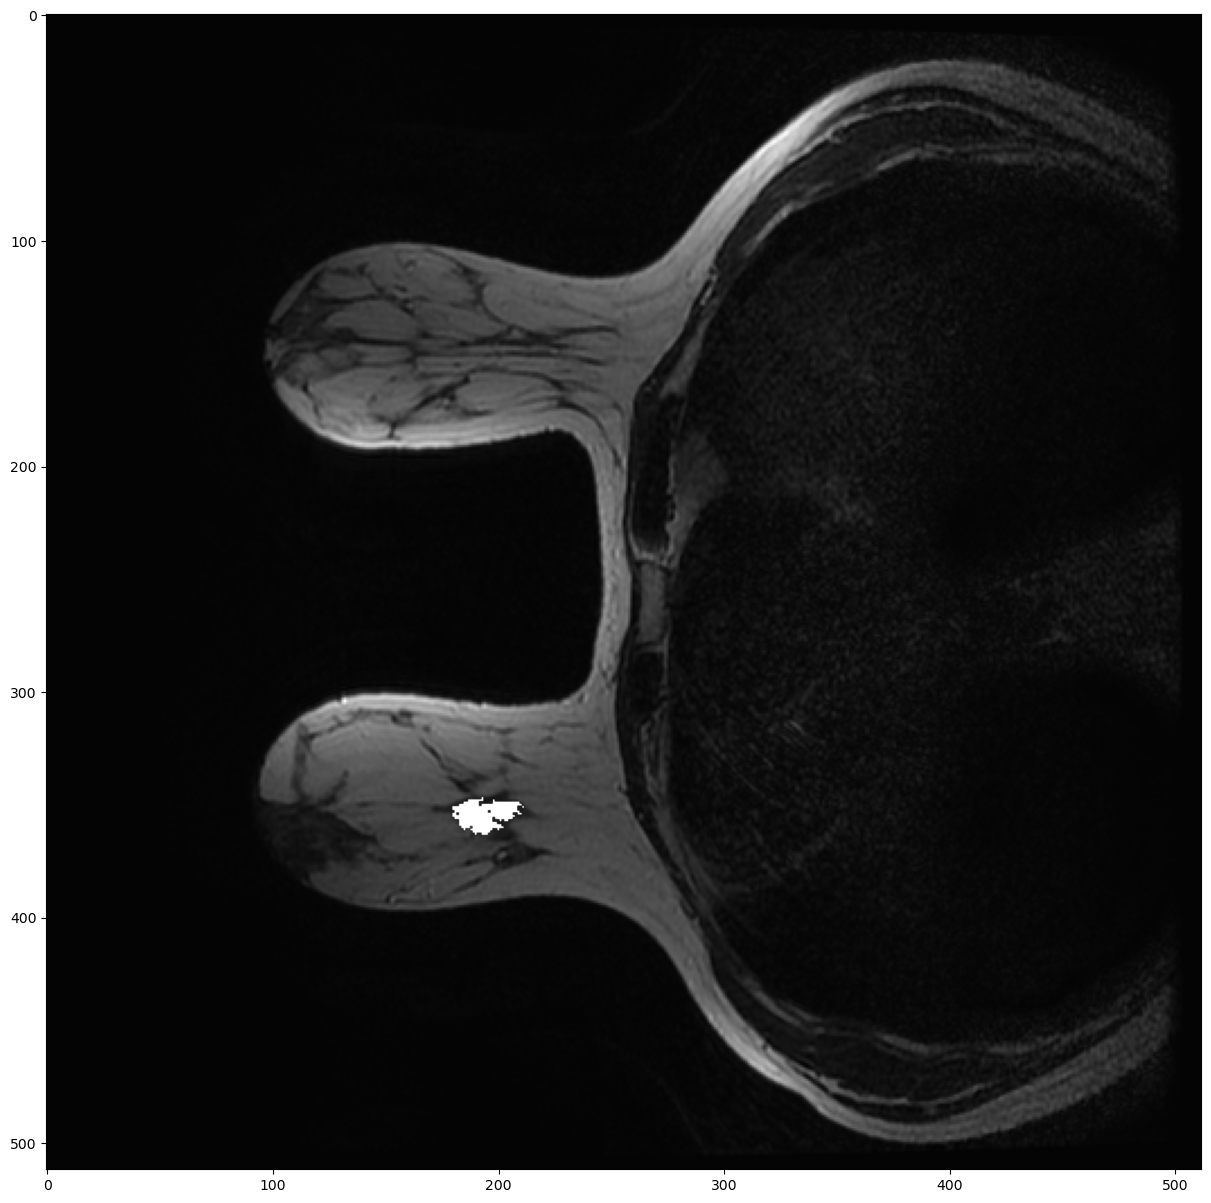

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(img.get_fdata()[::-1,:,83], cmap = plt.cm.grey)
plt.imshow(roi_img.get_fdata()[::-1,:,83], cmap = plt.cm.grey, alpha = (roi_img.get_fdata()[::-1,:,83] > 0).astype(float))

# Convert REGISTERED AX T2 FSE

In [4]:
lesions_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
lesions_df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


In [27]:
nifti_dir = "/media/bendico765/Crucial X9/MRI Lesions/NiftiFiles"

# create the directory for the numpy files
try:
    os.mkdir(f"{nifti_dir}")
except FileExistsError:
    pass

# create a README file
with open(f"{nifti_dir}/README.txt", "w") as file:
    file.write("Per ogni paziente la MRI e le roi sono state convertite in formato NIFTI. Per ciascuna ROI è stato salvato sia l'aspetto orignale che la versione ripulita da componenti disconesse e buchi")

for patient_id in lesions_df["Patient ID"].unique():
    print(f"Converting patient {patient_id}")
    for index, (_, row) in enumerate(lesions_df[lesions_df["Patient ID"] == patient_id].iterrows()):
        dicom_dir = row["Registered Ax T2 FSE path"]
        volume_3d = get_3d_shape(read_dicomdir(dicom_dir))
        original_roi = np.load(row["Roi mask Filepath"]).astype("int8")
        cleaned_roi = np.load(row["Cleaned Roi mask Filepath"]).astype("int8")
        
        # get the affine matrix from a dicom slice
        affine_matrix = nibabel.nicom.dicomwrappers.wrapper_from_file(f"{dicom_dir}/1-001.dcm").affine
    
        # if it doesn't exist, create the directory for the REGISTERED T2 FSE file
        Path(f"{nifti_dir}/{patient_id}/Registered Ax T2 FSE").mkdir(parents=True, exist_ok=True)
        
        # convert from dicom to nifti
        nifti_image = nib.Nifti1Image(np.transpose(volume_3d, (2,1,0))[:,:,:], affine_matrix)
        nib.save(nifti_image, f"{nifti_dir}/{patient_id}/Registered Ax T2 FSE/{patient_id}.nii")
    
        # create the roi folder if doesn't exist
        Path(f"{nifti_dir}/{patient_id}/ROI").mkdir(parents=True, exist_ok=True)

        # create the subfolders for the roi files
        Path(f"{nifti_dir}/{patient_id}/ROI/Original").mkdir(parents=True, exist_ok=True)
        Path(f"{nifti_dir}/{patient_id}/ROI/Cleaned").mkdir(parents=True, exist_ok=True)
        
        # save the original roi mask in nifti format
        nifti_original_roi = nib.Nifti1Image(np.transpose(original_roi, (2,1,0))[:,:,:], affine_matrix)
        nib.save(nifti_original_roi, f"{nifti_dir}/{patient_id}/ROI/Original/ROI {index}")

        nifti_cleaned_roi = nib.Nifti1Image(np.transpose(cleaned_roi, (2,1,0))[:,:,:], affine_matrix)
        nib.save(nifti_cleaned_roi, f"{nifti_dir}/{patient_id}/ROI/Cleaned/ROI {index}")

Converting patient AMBL-001
Converting patient AMBL-003
Converting patient AMBL-004
Converting patient AMBL-005
Converting patient AMBL-007
Converting patient AMBL-008
Converting patient AMBL-009
Converting patient AMBL-010
Converting patient AMBL-011
Converting patient AMBL-013
Converting patient AMBL-016
Converting patient AMBL-018
Converting patient AMBL-022
Converting patient AMBL-023
Converting patient AMBL-024
Converting patient AMBL-025
Converting patient AMBL-026
Converting patient AMBL-028
Converting patient AMBL-029
Converting patient AMBL-031
Converting patient AMBL-032
Converting patient AMBL-033
Converting patient AMBL-034
Converting patient AMBL-035
Converting patient AMBL-036
Converting patient AMBL-038
Converting patient AMBL-042
Converting patient AMBL-043
Converting patient AMBL-044
Converting patient AMBL-045
Converting patient AMBL-046
Converting patient AMBL-047
Converting patient AMBL-049
Converting patient AMBL-050
Converting patient AMBL-496
Converting patient A

# Convert REGISTERED MULTIPHASE

In [6]:
lesions_df = pd.read_csv("/media/bendico765/Crucial X9/MRI Lesions/lesions_df.csv", index_col=0)
lesions_df.head()

,Patient ID,tumor/benign,Registered Ax T2 FSE path,Slice Location,Breast,z_indexes,y_indexes,x_indexes,z_offset,y_offset,x_offset,Roi mask Filepath,Cleaned Roi mask Filepath,Pixel Spacing,Slice Thickness,RobustScaled Registered Ax T2 FSE path
0,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-60.85,L,"[82, 83, 84, 85, 86, 87]","[172, 173, 174, 175, 176, 177, 178, 179, 180, ...","[142, 143, 144, 145, 146, 147, 148, 149, 150, ...",6,42,23,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
1,AMBL-001,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-56.85,R,"[82, 83, 84, 85]","[188, 189, 190, 191, 192, 193, 194, 195, 196, ...","[360, 361, 362, 363, 364, 365, 366, 367, 368, ...",4,46,17,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
12,AMBL-003,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-2.76,R,"[49, 50, 51, 52, 53, 54, 55]","[178, 179, 180, 181, 182, 183, 184, 185, 186, ...","[357, 358, 359, 360, 361, 362, 363, 364, 365, ...",7,40,21,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
18,AMBL-004,0.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-51.98,L,"[81, 82, 83, 84, 85]","[163, 164, 165, 166, 167, 168, 169, 170, 171, ...","[147, 148, 149, 150, 151, 152, 153, 154, 155, ...",5,18,13,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...
24,AMBL-005,1.0,/media/bendico765/Crucial X9/MRI Lesions/manif...,-28.46,R,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 6...","[194, 195, 196, 197, 198, 199, 200, 201, 202, ...","[379, 380, 381, 382, 383, 384, 385, 386, 387, ...",13,55,47,/media/bendico765/Crucial X9/MRI Lesions/Roi m...,/media/bendico765/Crucial X9/MRI Lesions/Clean...,0.6641,2.0,/media/bendico765/Crucial X9/MRI Lesions/Robus...


## Assign Registered AX Sen Vibrant MultiPhase to each patient

In [7]:
lesions_df["Registered AX Sen Vibrant MultiPhase path"] = [
    [roots for roots, dirs, files in os.walk("/".join(row["Registered Ax T2 FSE path"].split("/")[:-1])) if "Registered AX Sen Vibrant MultiPhase" in roots][0]
    for _, row in lesions_df.iterrows()
]

In [13]:
lesions_df["Registered AX Sen Vibrant MultiPhase path"].values[0]

'/media/bendico765/Crucial X9/MRI Lesions/manifest-1728494830954/Advanced-MRI-Breast-Lesions/AMBL-001/03-05-2004-NA-MRI BREASTS - Delayed contrast-93547/500.000000-Registered AX Sen Vibrant MultiPhase-85715'

## Produce the NIFTI files

In [31]:
dicom_dir = lesions_df.at[0, "Registered AX Sen Vibrant MultiPhase path"]
mask = lesions_df.at[0, "Cleaned Roi mask Filepath"]
volumes = get_multiphase_mri(lesions_df.at[0, "Registered AX Sen Vibrant MultiPhase path"])

In [32]:
# get the affine matrix from a dicom slice
affine_matrix = nibabel.nicom.dicomwrappers.wrapper_from_file(f"{dicom_dir}/1-001.dcm").affine

In [33]:
# convert from dicom to nifti
for index, volume_3d in enumerate(volumes):
    nifti_image = nib.Nifti1Image(np.transpose(volume_3d, (2,1,0))[:,:,:], affine_matrix)
    nib.save(nifti_image, f"/media/bendico765/Crucial X9/multiphase_test_{index}.nii")

In [43]:
patients = [
    "AMBL-001",
    "AMBL-004",
    "AMBL-562",
    "AMBL-595",
    "AMBL-629"
]

tmp_df = lesions_df[lesions_df["Patient ID"].isin(patients)][["Patient ID", "Registered AX Sen Vibrant MultiPhase path"]].drop_duplicates("Patient ID")
tmp_df.head()

,Patient ID,Registered AX Sen Vibrant MultiPhase path
0,AMBL-001,/media/bendico765/Crucial X9/MRI Lesions/manif...
18,AMBL-004,/media/bendico765/Crucial X9/MRI Lesions/manif...
774,AMBL-562,/media/bendico765/Crucial X9/MRI Lesions/manif...
972,AMBL-595,/media/bendico765/Crucial X9/MRI Lesions/manif...
1176,AMBL-629,/media/bendico765/Crucial X9/MRI Lesions/manif...


In [49]:
for _, row in tmp_df.iterrows():
    patient_id = row["Patient ID"]
    dicom_dir = row["Registered AX Sen Vibrant MultiPhase path"]
    volumes = get_multiphase_mri(dicom_dir)

    affine_matrix = nibabel.nicom.dicomwrappers.wrapper_from_file(f"{dicom_dir}/1-001.dcm").affine

    # if it doesn't exist, create the directory for the REGISTERED MULTIPHASE file
    Path(f"/media/bendico765/Crucial X9/MRI Lesions/Nifti 20-12/{patient_id}/Registered AX Sen Vibrant MultiPhase").mkdir(parents=True, exist_ok=True)
    
    print(f"Converting patient {patient_id}")
    for index, volume_3d in enumerate(volumes):
        nifti_image = nib.Nifti1Image(np.transpose(volume_3d, (2,1,0))[:,:,:], affine_matrix)
        nib.save(
            nifti_image, 
            f"/media/bendico765/Crucial X9/MRI Lesions/Nifti 20-12/{patient_id}/Registered AX Sen Vibrant MultiPhase/{patient_id}_Phase{index+1}.nii"
        )

Converting patient AMBL-001
Converting patient AMBL-004
Converting patient AMBL-562
Converting patient AMBL-595
Converting patient AMBL-629
